In [ ]:
import sklearn
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

pd.set_option('display.max_columns', None) #display all the columns in pandas head function

np.random.seed(42)
tf.random.set_seed(42)

from urllib.parse import urlparse,urlencode
import ipaddress
import re
import requests
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import  cross_val_score, StratifiedKFold

random_state = 42
cv_results = np.array([])
cv_means = []
cv_std = []
cvk=10


In [ ]:
#getting the data from the dataset
df =pd.read_csv('malicious_phish.csv')
#df.drop("Unnamed: 0",axis=1,inplace=True)
#in case you are using local machine
#df =pd.read_csv('./malicious_phish.csv')

In [ ]:
!python -V

Python 3.10.12


In [ ]:
#df.drop("Unnamed: 0",axis=1,inplace=True)
df.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [ ]:
df.shape

(30158, 2)

As can be seen the dataset is composed of many rows (instances), but it has only two columns and one of these two columns is the target value, which only leave one column for us to train our model. ofcourse this is infeasible, therefore we will conduct feature extraction from the first column before we do anything else inorder to make our model work

but before we begin the feature extraction process let see the distribution of our label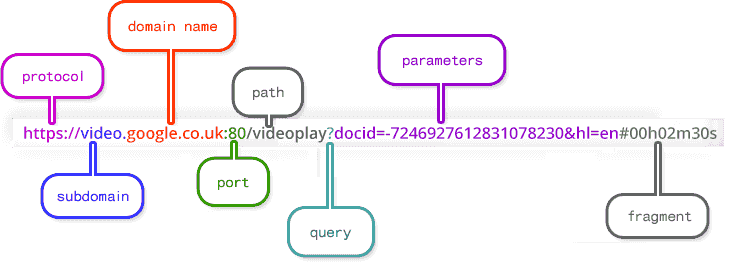

In [ ]:
df["type"].describe()

count      30157
unique         4
top       benign
freq       22105
Name: type, dtype: object

([<matplotlib.patches.Wedge at 0x7a7607437670>,
 [Text(-0.7351802771661989, 0.8182358829004208, 'Benign'),
  Text(0.5005071610189443, -0.979536922105929, 'Defacement'),
  Text(1.0383891814769606, -0.3629709462086573, 'Phishing'),
  Text(1.0967683092821339, -0.0842572000152501, 'Malware')])

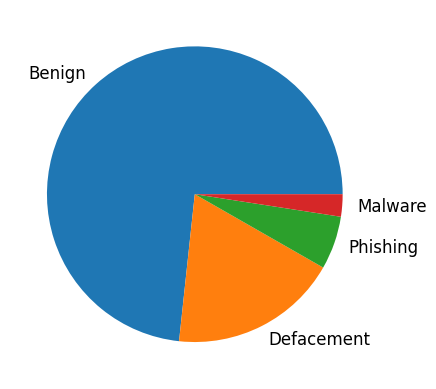

In [ ]:
lis=[df["type"].value_counts()[0],df["type"].value_counts()[1],df["type"].value_counts()[2],df["type"].value_counts()[3]]
plt.pie(lis,labels=["Benign","Defacement","Phishing","Malware"])

As can be seen above we have four classes, which means our task is considered to be a multi-class task, further more the "benign" label is the label with the most occurance, so we will need to take that into our consideration when we evaluate our model

**URL Components Extraction**

In [ ]:
df["original_url"]=df["url"]

In [ ]:
def fix_url(url): #if no protocol (scheme) is used assume the general case of http, this is needed to make the urlparse function works
  if not urlparse(url).scheme:
        return f"http://{url}"
  return url

In [ ]:
def get_protocol(url):
  protocol, _, _, _, _, _ = urlparse(url.replace("[","").replace("]","").strip() )
  return protocol

In [ ]:
def get_host(url):
  _, host, _, _, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return host

In [ ]:
def get_path(url):
  _, _, path, _, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return path

In [ ]:
def get_parameters(url):
  _, _, _, parameters, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return parameters

In [ ]:
def get_query(url):
  _, _, _, _, query, _ = urlparse(url.replace("[","").replace("]","").strip())
  return query

In [ ]:
def get_fragment(url):
  _, _, _, _, _, fragment = urlparse(url.replace("[","").replace("]","").strip())
  return fragment

In [ ]:
df["url"]=df["url"].apply(fix_url)

In [ ]:
df["protocol"]=df["url"].apply(get_protocol)
df["host"]=df["url"].apply(get_host)
df["path"]=df["url"].apply(get_path)
df["parameters"]=df["url"].apply(get_parameters)
df["query"]=df["url"].apply(get_query)
df["fragment"]=df["url"].apply(get_fragment)

In [ ]:
df.head()

,url,type,original_url,protocol,host,path,parameters,query,fragment
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,,,,
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html,,,
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm,,,
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php,,option=com_content&view=article&id=70&vsig70_0=15,
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php,,option=com_mailto&tmpl=component&link=aHR0cDov...,


Now that we have extracted all the components, let analyze it to see which components is revelant to our analysis

In [ ]:
df = df.replace('', np.nan) #fill empty values with Nan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30158 entries, 0 to 30157
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           30158 non-null  object
 1   type          30157 non-null  object
 2   original_url  30158 non-null  object
 3   protocol      30158 non-null  object
 4   host          30152 non-null  object
 5   path          28880 non-null  object
 6   parameters    12 non-null     object
 7   query         6755 non-null   object
 8   fragment      2 non-null      object
dtypes: object(9)
memory usage: 2.1+ MB


As can be seen the Parameters , Query and Fragment has many empty values, therefore we can safely drop such a features.

The host (domain name) part has 183 empty values, having a url with no domain name doesn't make alot of sense in our project, also 183 is relatively a small amount compared to the whole dataset, therefore we can safely drop all the instance that has no domain name

In [ ]:
df.drop(['parameters', 'query','fragment'], axis = 1,inplace=True)
df.dropna(subset = ['host'],inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30152 entries, 0 to 30157
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           30152 non-null  object
 1   type          30151 non-null  object
 2   original_url  30152 non-null  object
 3   protocol      30152 non-null  object
 4   host          30152 non-null  object
 5   path          28874 non-null  object
dtypes: object(6)
memory usage: 1.6+ MB


Finally the Path part also has some missing values;however it consistes a huge portion of our datasets,also having such an empty path in a url is normal for example "www.google.com",therefore we will fill these empty values with spaces,as this will not affect the next process as we will see soon.

In [ ]:
df.fillna("",inplace=True)

In [ ]:
df.reset_index(drop=True,inplace=True)

**Feature Extraction**

We will begin our feature extraction journey by extracting features related to the whole URL itself, after that more features will be extracted for every component individually

**URL Features**

Presense of an IP address in the URL

Every website has an IP address associated with it, which is simpliy used to tell your device where to direct it's requests. most websites has a Domain name assosiated with it's IP to make it easier for us (as humans) to remeber how to access a certain website.

every website is accessable using either its IP address of it name, and here we will check whether a URL in the dataset is IP or name based:

In [ ]:
def ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

df['ip_address'] = df['url'].apply(ip_address)

Special symbols in the URL

Most of the time malicious URLs contains specail symbols that might alter how the bowser treats such URL, for example the "@" symbol leads the browser to ignore everything preceding it, which means that the real address where you will be redirected is ofter after such symbol, hence an attacker can inject the name of a legitimate URL before it to trick you into visiting such website.


Another popularly used symbol is the " - " which is rarely used in legitimate websites, but used alot in malicious ones inorder to make the domain name looks good for the user and remove an suspiciousness that the user might have, or to trick the user into beliveing that he is visiting a legitimate website. for example a malicious website that imitate the facebook might look like this "www.face-book.com", unless the user is carefull, he can fall easliy in such simple trick.

The following is a list of some popularly used symbols in URLs

? - = . # % + $ ! * ,

In [ ]:
def specialSymbols(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"URL_{symbol}"] = df['url'].apply(lambda i: i.count(symbol))

specialSymbols(df)

**Length of the URL**

The official length of a URL is 2048 characters, so regardless whether a URL is malicious or not, it has to obay this rule. Begnin websites normally uses short URLs, on the otherside some malicious websites uses long URLs to hide some information such as the special symbols mentioned above, therefore such feature might be useful in our analysis

In [ ]:
def getLength(url):
  return len(url)

In [ ]:
df["length"] = df["url"].apply(getLength)

**Usage of a URL Shortening Services**

Using URL Shortening Services is a third party websites that is used to convert long URLs in short ones using the http redirect on the domain name of the shorting service website.

such service is used by many attackers to hide some of the info in the original URL (the long URL), and to trick the users into beliving that the website is safe,as theses services is seen alot by the users in thier daily browsing.

In [ ]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['Shortining'] = df['url'].apply(Shortining_Service)

**Digits counts in a URL**

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [ ]:
df['digits_in_url']= df['url'].apply(digit_count)

**letters counts in a URL**

It might also be useful to include the letter count in our analysis,if this feature turns out to be useless we can always drop it out

In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [ ]:
df['letters_in_url']= df['url'].apply(letter_count)

**E-mail Address in URL**

It's pretty rare to find an E-mail address inside of a websites URL, most big websites avoid having an E-mail address inside any of thier URLs to protect the users privacy and to protect the users from spam bots that might detect such E-mails and start sending advertisments to it, therefore having an E-mail inside a URL might be a good indication about the type of the URL that a person might visit.

In [ ]:
def EmailAddress(url):
    if re.findall(r'[\w\.-]+@[\w\.-]+', url):
        return 1
    else:
        return 0

df['email_address']= df['url'].apply(EmailAddress)

**Counting vowels**

In [ ]:
def vowels_count(url):
    vowels = ['a', 'e', 'i', 'o', 'u']
    count = 0
    for i in vowels:
        count += url.lower().count(i)
    return count

In [ ]:
df['vowels_url']= df['url'].apply(vowels_count)

**TLD count**

A top-level domain is a group of letters that appear as part of a website address URL, for exmaple if we have the following URL : "www.google.com", the TLD is ".com" , it is mainly used for DNS resolving.

Typically a website might has 1 or 2 TLDs in its URL.

In this feature we have a list of all of the possible TLDs, and will use it to count the TLDs inside of a URL

In [ ]:
tld_file = open('tlds.txt', 'r') #displaying the TLDs list

print(tld_file.readlines() )

tld_file.close()

['aaa\n', 'aarp\n', 'abarth\n', 'abb\n', 'abbott\n', 'abbvie\n', 'abc\n', 'able\n', 'abogado\n', 'abudhabi\n', 'ac\n', 'academy\n', 'accenture\n', 'accountant\n', 'accountants\n', 'aco\n', 'actor\n', 'ad\n', 'adac\n', 'ads\n', 'adult\n', 'ae\n', 'aeg\n', 'aero\n', 'aetna\n', 'af\n', 'afl\n', 'africa\n', 'ag\n', 'agakhan\n', 'agency\n', 'ai\n', 'aig\n', 'airbus\n', 'airforce\n', 'airtel\n', 'akdn\n', 'al\n', 'alfaromeo\n', 'alibaba\n', 'alipay\n', 'allfinanz\n', 'allstate\n', 'ally\n', 'alsace\n', 'alstom\n', 'am\n', 'amazon\n', 'americanexpress\n', 'americanfamily\n', 'amex\n', 'amfam\n', 'amica\n', 'amsterdam\n', 'analytics\n', 'android\n', 'anquan\n', 'anz\n', 'ao\n', 'aol\n', 'apartments\n', 'app\n', 'apple\n', 'aq\n', 'aquarelle\n', 'ar\n', 'arab\n', 'aramco\n', 'archi\n', 'army\n', 'arpa\n', 'art\n', 'arte\n', 'as\n', 'asda\n', 'asia\n', 'associates\n', 'at\n', 'athleta\n', 'attorney\n', 'au\n', 'auction\n', 'audi\n', 'audible\n', 'audio\n', 'auspost\n', 'author\n', 'auto\n', 'aut

In [ ]:
tld_file = open('tlds.txt', 'r')
def TLD_count(url):
    tldcount = 0
    tld_list=tld_file.readlines()
    line=0
    while (line < len(tld_list)):
       if tld_list[line].rstrip() in url :
          tldcount+=1
          line+=10
       line+=1
    if(".php" in url):
      tldcount-=1;
    if(".html" in url):
      tldcount-=1;

    tld_file.seek(0)
    return tldcount

df['tld_count']= df['url'].apply(TLD_count)

**Precense of the word 'Server' or 'Client'**

In [ ]:
def check_word_server_client(url):
    if "server" in url.lower() or "client" in url.lower():
        return 1
    return 0
df['server_client']= df['url'].apply(check_word_server_client)

**protocol type**

in our dataset we have three types of protocols ,http, https, and ftp, for each of such protocols we will create a feature that indicates if the url uses such protocol

we will not use the protocol feature that we extracted here because we filled the urls that doesn't contain any url with http to make the urlparse function work.

Usage of https

https (Hyper Text Transfer Protocol Secure) is a protocol built on the http protocol with the addition of an encryption layer, which means that the connection between your browser and the target website is secure and can not be intercepted by a malicious entity, it is a common misunderstanding nowadays that all https websites are safe, this is true in term of the connection only,not the website itself as anyone could implement such protocol easily in his website to trick users into entering it.

In [ ]:
def https(url):
    if str(urlparse(url).scheme)=='https':
        return 1
    else:
        return 0

df['https'] = df['original_url'].apply(https)

In [ ]:
def http(url):
    if str(urlparse(url).scheme)=='http':
        return 1
    else:
        return 0

df['http'] = df['original_url'].apply(http)

In [ ]:
def ftp(url):
    if str(urlparse(url).scheme)=='ftp':
        return 1
    else:
        return 0

df['ftp'] = df['original_url'].apply(ftp)

**Path Features**

As for the path features we will extract simillar features as the ones we extracted for the URL

In [ ]:
def specialSymbols2(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"path_{symbol}"] = df['path'].apply(lambda i: i.count(symbol))

specialSymbols2(df)

In [ ]:
df["path_length"] = df["path"].apply(getLength)
df['path_digits_in_url']= df['path'].apply(digit_count)
df['path_letters_in_url']= df['path'].apply(letter_count)
df['path_vowels_url']= df['path'].apply(vowels_count)

**Host Features**

**Digits counts in a domain name**

Digits inside a URL's domain can also be an indication of the status of a website in term of it being benigin or not,a malicious entity can use numarical digits inorder to trick the user into beliving that he is visiting a normal website. for example an attacker might make a website with the following URL "www.facebo0k.com", notice that the second "o" is actually a zero, and anyone can easily fall in this simple trick

In [ ]:
def specialSymbols3(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"host_{symbol}"] = df['host'].apply(lambda i: i.count(symbol))

specialSymbols3(df)

<ipython-input-86-9cb445b3f66b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"host_{symbol}"] = df['host'].apply(lambda i: i.count(symbol))
<ipython-input-86-9cb445b3f66b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"host_{symbol}"] = df['host'].apply(lambda i: i.count(symbol))
<ipython-input-86-9cb445b3f66b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

In [ ]:
df["host_length"] = df["host"].apply(getLength)
df['host_digits_in_url']= df['host'].apply(digit_count)
df['host_letters_in_url']= df['host'].apply(letter_count)
df['host_vowels_url']= df['host'].apply(vowels_count)

<ipython-input-87-2e063700897c>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["host_length"] = df["host"].apply(getLength)
<ipython-input-87-2e063700897c>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['host_digits_in_url']= df['host'].apply(digit_count)
<ipython-input-87-2e063700897c>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-frag

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30152 entries, 0 to 30151
Columns: 116 entries, url to host_vowels_url
dtypes: int64(110), object(6)
memory usage: 26.7+ MB


**Feature Engineering**

Now that we have extracted all the features that we need, let take a look at it once again

In [ ]:
df.head()

,url,type,original_url,protocol,host,path,ip_address,URL__,URL_&,URL_~,"URL_""",URL_',URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_!,URL_*,"URL_,",URL_//,URL_/,URL_;,URL_:,URL_>,URL_<,URL_^,URL_[,URL_],URL_{,URL_},URL_(,URL_),length,Shortining,digits_in_url,letters_in_url,email_address,vowels_url,tld_count,server_client,https,http,ftp,path__,path_&,path_~,"path_""",path_',path_@,path_?,path_-,path_=,path_.,path_#,path_%,path_+,path_$,path_!,path_*,"path_,",path_//,path_/,path_;,path_:,path_>,path_<,path_^,path_[,path_],path_{,path_},path_(,path_),path_length,path_digits_in_url,path_letters_in_url,path_vowels_url,host__,host_&,host_~,"host_""",host_',host_@,host_?,host_-,host_=,host_.,host_#,host_%,host_+,host_$,host_!,host_*,"host_,",host_//,host_/,host_;,host_:,host_>,host_<,host_^,host_[,host_],host_{,host_},host_(,host_),host_length,host_digits_in_url,host_letters_in_url,host_vowels_url
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,23,0,0,17,0,4,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,13,4
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,4,0,1,0,0,0,0,0,0,0,0,0,42,0,1,33,0,9,11,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,24,0,20,6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,9,3
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,5,0,1,0,0,0,0,0,0,0,0,0,38,0,1,29,0,6,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,17,1,12,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,13,4
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php,0,2,3,0,0,0,0,1,1,4,3,0,0,0,0,0,0,0,1,3,0,1,0,0,0,0,0,0,0,0,0,88,0,7,63,0,22,19,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,10,0,8,2,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,18,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php,0,1,2,0,0,0,0,1,1,3,2,0,0,0,0,0,0,0,1,3,0,1,0,0,0,0,0,0,0,0,0,235,0,22,199,0,37,30,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,10,0,8,2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,21,10


In [ ]:
df.describe()

,ip_address,URL__,URL_&,URL_~,"URL_""",URL_',URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_!,URL_*,"URL_,",URL_//,URL_/,URL_;,URL_:,URL_>,URL_<,URL_^,URL_[,URL_],URL_{,URL_},URL_(,URL_),length,Shortining,digits_in_url,letters_in_url,email_address,vowels_url,tld_count,server_client,https,http,ftp,path__,path_&,path_~,"path_""",path_',path_@,path_?,path_-,path_=,path_.,path_#,path_%,path_+,path_$,path_!,path_*,"path_,",path_//,path_/,path_;,path_:,path_>,path_<,path_^,path_[,path_],path_{,path_},path_(,path_),path_length,path_digits_in_url,path_letters_in_url,path_vowels_url,host__,host_&,host_~,"host_""",host_',host_@,host_?,host_-,host_=,host_.,host_#,host_%,host_+,host_$,host_!,host_*,"host_,",host_//,host_/,host_;,host_:,host_>,host_<,host_^,host_[,host_],host_{,host_},host_(,host_),host_length,host_digits_in_url,host_letters_in_url,host_vowels_url
count,30152.000000,30152.000000,30152.000000,30152.000000,30152.0,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.0,30152.0,30152.0,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.00000,30152.000000,30152.000000,30152.0,30152.000000,30152.00000,30152.000000,30152.0,30152.000000,30152.000000,30152.0,30152.000000,30152.00000,30152.000000,30152.0,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.000000,30152.0,30152.000000,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.000000,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.0,30152.000000,30152.000000,30152.000000,30152.000000
mean,0.000796,0.451711,0.424549,0.006235,0.0,0.001658,0.000730,0.226353,1.812218,0.655877,1.955559,0.000066,0.626260,0.083212,0.000133,0.000829,0.000166,0.003051,1.002089,4.260248,0.006733,1.052169,0.0,0.0,0.0,0.003118,0.003151,0.000099,0.000099,0.007827,0.007761,64.571969,0.059167,4.688246,48.283431,0.000298,15.668845,15.702872,0.00262,0.003880,0.287676,0.0,0.312782,0.00136,0.006235,0.0,0.001227,0.000696,0.0,1.570841,0.00388,0.464513,0.0,0.479836,0.055784,0.000033,0.000531,0.000033,0.002852,0.000365,2.242073,0.000033,0.003814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007330,0.007330,29.968924,3.017644,21.784790,7.601817,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.104338,0.0,1.428064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.443221,0.180021,14.730731,5.335898
std,0.028202,1.215601,1.302054,0.090111,0.0,0.046757,0.028204,0.430124,3.261932,1.605120,1.160790,0.008144,5.089401,0.662219,0.014106,0.044228,0.017276,0.142903,0.050492,1.531997,0.171386,0.306418,0.0,0.0,0.0,0.056926,0.057215,0.009974,0.009974,0.094306,0.092894,37.231091,0.235941,8.536137,26.801340,0.017275,9.517981,6.029119,0.05112,0.062172,0.452687,0.0,1.135057,0.06690,0.090111,0.0,0.039463,0.027611,0.0,3.198603,0.09367,0.595274,0.0,4.387425,0.537233,0.005759,0.030469,0.005759,0.142209,0.019097,1.502390,0.005759,0.076089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090213,0.090213,28.794057,6.917756,20.113449,7.668999,0.005759,0.0,0.0,0.0,0.0,0.0,0.0,0.387773,0.0,0.727645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.056162,0.951562,6.402901,2.602227
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,7.000000,0.000000,0.0

As can be seen some of the features above has only zero values, therefore we will be dropping it as it will be useless for our model

In [ ]:
df.drop(["path_?","path_#","path_[","path_]","host_?","host_#","host_,","host_//","host_/","host_[","host_]",],axis=1,inplace=True)

The Protocol attribute should also be dropped as we have already expanded it to three features :http, https, ftp

In [ ]:
df.drop(["protocol"],axis=1,inplace=True)

we also need to drop the categorical columns such as the url , host, path, as we have already extracted the features that we need from it

In [ ]:
df.drop(["url","path","host","original_url"],axis=1,inplace=True)

It can be seen that some of the features has a really low mean, this indicates that such features rarely appeares in any URL, Therefore we will merge some of these features together to reduce the dimensionality

In [ ]:
df["host_><^{}()!;:~"]=df["host_<"]+df["host_>"]+df["host_^"]+df["host_}"] +df["host_{"]+df["host_("] +df["host_)"]+df["host_!"]+df["host_;"]+df["host_:"]+df["host_~"]
df.drop(["host_<","host_>","host_^","host_}","host_{","host_(","host_)","host_!","host_:","host_;"],axis=1,inplace=True)

<ipython-input-94-a7ebc9a89e52>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["host_><^{}()!;:~"]=df["host_<"]+df["host_>"]+df["host_^"]+df["host_}"] +df["host_{"]+df["host_("] +df["host_)"]+df["host_!"]+df["host_;"]+df["host_:"]+df["host_~"]


In [ ]:
df["path_><^{}()!;:'~"]=df["path_<"]+df["path_>"]+df["path_^"]+df["path_}"] +df["path_{"]+df["path_("] +df["path_)"]+df["path_!"]+df["path_;"]+df["path_:"]+df["path_'"]+df['path_"']+df['path_~']
df.drop(["path_<","path_>","path_^","path_}","path_{","path_(","path_)","path_!","path_:","path_;",'path_"',"path_'",'path_~'],axis=1,inplace=True)

In [ ]:
df["URL_><^{}()[]!;:'~"]=df["URL_<"]+df["URL_>"]+df["URL_^"]+df["URL_}"] +df["URL_{"]+df["URL_("] +df["URL_)"]+df["URL_["]+df["URL_]"]+df["URL_!"]+df["URL_;"]+df["URL_:"]+df["URL_'"]+df['URL_"']+df['URL_~']
df.drop(["URL_<","URL_>","URL_^","URL_}","URL_{","URL_(","URL_)","URL_!","URL_:","URL_;","URL_[","URL_]","URL_'",'URL_"','URL_~'],axis=1,inplace=True)

In [ ]:
df['https+ftp']=df['https']+df['ftp']
df.drop(["https","ftp"],axis=1,inplace=True)

Finally we need to encode our labels inorder to be able to feed it into the ML algorithms

In [ ]:
df["type"] = df["type"].astype('category')
df["type"] = df["type"].cat.codes

Everything seems well too far however as most of the ML algorithms that we will be using next uses to gradient decsent algorithm, we need to make sure that our data has the same scale inorder to be able to converge fast to the optimal solution.

we will standarize our data for this porpose, so that it end up with 0 mean and a standard deviation of 1

In [ ]:
types=pd.DataFrame()
types["type"]=df["type"].copy()
df.drop(["type"],axis=1,inplace=True)

In [ ]:
columns=df.columns

In [ ]:
from sklearn.preprocessing import StandardScaler
stdScaler = StandardScaler()
df=stdScaler.fit_transform(df)

In [ ]:
df=pd.DataFrame(df,columns=columns)

In [ ]:
df.describe()

,ip_address,URL__,URL_&,URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_*,"URL_,",URL_//,URL_/,length,Shortining,digits_in_url,letters_in_url,email_address,vowels_url,tld_count,server_client,http,path__,path_&,path_@,path_-,path_=,path_.,path_%,path_+,path_$,path_*,"path_,",path_//,path_/,path_length,path_digits_in_url,path_letters_in_url,path_vowels_url,host__,host_&,host_~,"host_""",host_',host_@,host_-,host_=,host_.,host_%,host_+,host_$,host_*,host_length,host_digits_in_url,host_letters_in_url,host_vowels_url,host_><^{}()!;:~,path_><^{}()!;:'~,URL_><^{}()[]!;:'~,https+ftp
count,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,30152.0,30152.0,30152.0,30152.0,30152.0,3.015200e+04,30152.0,3.015200e+04,30152.0,30152.0,30152.0,30152.0,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04,3.015200e+04
mean,-1.131137e-17,-3.299150e-17,-3.723327e-17,5.655686e-18,-5.349337e-17,-9.426144e-19,-3.440543e-17,5.655686e-17,-2.827843e-18,2.403667e-17,3.416977e-17,3.770458e-18,-3.534804e-18,-3.770458e-18,2.190165e-15,2.563911e-16,-3.770458e-17,-4.253547e-17,7.069608e-18,-7.729438e-17,5.655686e-18,3.204889e-17,-4.288896e-17,1.154703e-17,-2.874974e-17,-9.426144e-18,-3.770458e-18,6.362647e-18,7.540915e-18,-2.356536e-17,2.450797e-17,7.069608e-18,-1.932360e-17,2.356536e-19,-4.713072e-19,7.187435e-18,-1.225399e-17,1.437487e-16,3.958980e-17,-6.598301e-18,6.598301e-18,5.561425e-17,-1.413922e-18,0.0,0.0,0.0,0.0,0.0,-4.006111e-18,0.0,-2.285840e-17,0.0,0.0,0.0,0.0,-2.003056e-16,-2.933887e-17,6.362647e-18,3.134193e-17,-9.426144e-19,-2.168013e-17,1.741480e-16,-1.366791e-17
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,0.0,0.0,0.0,0.0,0.0,1.000017e+00,0.0,1.000017e+00,0.0,0.0,0.0,0.0,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-2.822412e-02,-3.716013e-01,-3.260663e-01,-2.587047e-02,-5.262594e-01,-5.555750e-01,-4.086222e-01,-8.232105e-01,-8.144630e-03,-1.230539e-01,-1.256581e-01,-9.404712e-03,-9.598662e-03,-2.135199e-02,-4.138173e-02,-1.475385e+00,-1.358349e+00,-2.507743e-01,-5.492325e-01,-1.540375e+00,-1.727937e-02,-1.646263e+00,-2.272820e+00,-5.125369e-02,-6.354960e-01,-2.755696e-01,-2.032584e-02,-2.522525e-02,-4.911104e-01,-4.142640e-02,-7.803484e-01,-1.093679e-01,-1.038375e-01,-5.759027e-03,-5.759027e-03,-2.005685e-02,-1.910370e-02,-1.492363e+00,-1.040820e+00,-4.362244e-01,-1.083114e+00,-9.912562e-01,-5.759027e-03,0.0,0.0,0.0,0.0,0.0,-2.690740e-01,0.0,-5.882972e-01,0.0,0.0,0.0,0.0,-1.763484e+00,-1.891881e-01,-2.300672e+00,-2.050546e+00,-5.759027e-03,-1.183417e-01,-2.064483e-01,-6.241358e-02
25%,-2.822412e-02,-3.716013e-01,-3.260663e-01,-2.587047e-02,-5.262594e-01,-5.555750e-01,-4.086222e-01,-8.232105e-01,-8.144630e-03,-1.230539e-01,-1.256581e-01,-9.404712e-03,-9.598662e-03,-2.135199e-02,-4.138173e-02,-8.226315e-01,-6.868558e-01,-2.507743e-01,-5.492325e-01,-6.821948e-01,-1.727937e-02,-7.006691e-01,-7.800394e-01,-5.125369e-02,-6.354960e-

with this our features hasa mean of approximitly zero , and a standard deviation of one

let add the labels back

In [ ]:
df["type"]=types["type"]

Now we will split our dataset into train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

y = df["type"]
X = df.drop(labels = ["type"], axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [ ]:
y_test.describe()

count    6031.000000
mean        1.409551
std         0.786116
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: type, dtype: float64

In [ ]:
y_train.describe()

count    24121.000000
mean         1.407404
std          0.803275
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: type, dtype: float64

as we have discussed above our dataset is not balaced,causing the mean and the std in each set to be slightly different , therefore we will be using stratified splitting to insure that the same percentage of url labels exist within each set, this will help us in evalutaing our model more accurately.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df["type"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train =  strat_train_set.drop("type",axis=1)
y_train =  strat_train_set["type"]
X_test  =   strat_test_set.drop("type",axis=1)
y_test  =   strat_test_set["type"]

In [ ]:
y_test.describe()

count    6031.000000
mean        1.409551
std         0.786116
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: type, dtype: float64

In [ ]:
y_train.describe()

count    24121.000000
mean         1.407404
std          0.803275
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: type, dtype: float64

As can be seen from above, both sets have approximiatly equal percentage of each class, this can be observed by compairing the mean and the standared deviation of each set

**Machine Learning**

**Decision Tree**

In [ ]:
model_DT=DecisionTreeClassifier(random_state=random_state)

scores=cross_val_score(model_DT, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


array([0.89124539, 0.88280689, 0.86255098, 0.89941089, 0.88977119,
       0.84782638, 0.87564418, 0.89256959, 0.8734098 , 0.90773803])

In [ ]:
model_DT=DecisionTreeClassifier(random_state=random_state) # you dont have to run the above cell to diplay the confucsion matrix, only this one.
results_DT=cross_val_predict(model_DT,X_train,y_train,cv=cvk)

In [ ]:
cm = confusion_matrix(y_train , results_DT, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("DT_cm.png",bbox_inches='tight' )
#files.download("DT_cm.png")

**Random Forest**

In [ ]:
random_state = 42

model_RF=RandomForestClassifier(random_state=random_state)

scores=cross_val_score(model_RF, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


array([0.88703161, 0.89628661, 0.88472988, 0.92420235, 0.88146201,
       0.88054309, 0.88950017, 0.89118531, 0.89258541, 0.91605661])

In [ ]:
model_RF=RandomForestClassifier(random_state=random_state)

results_RF=cross_val_predict(model_RF,X_train,y_train,cv=cvk)

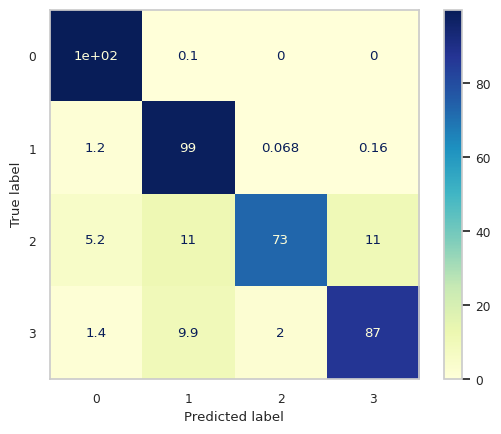

In [ ]:
cm = confusion_matrix(y_train , results_RF, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" )

plt.savefig("RF_cm.png",bbox_inches='tight')
#files.download("RF_cm.png")

In [ ]:
print(classification_report(y_train,results_RF))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00     17733
           2       0.95      0.99      0.97      4380
           3       0.93      0.73      0.82       577
           4       0.95      0.87      0.91      1431

    accuracy                           0.98     24121
   macro avg       0.96      0.89      0.92     24121
weighted avg       0.98      0.98      0.98     24121



In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print("accuracy = " + str (accuracy_score(y_train,results_RF)))
print("precision = " + str (precision_score(y_train,results_RF,average="macro")))
print("recall = " + str (recall_score(y_train,results_RF,average="macro")))
print("F1 = " + str (f1_score(y_train,results_RF,average="macro")))
#print("FPR = " + str (FPR.mean()))

accuracy = 0.9821732100659176
precision = 0.955201758691729
recall = 0.8943245324914294
F1 = 0.9211232037507262


**Logistic Regression**

In [ ]:
random_state = 42

model_LR=LogisticRegression(random_state=random_state)

scores=cross_val_score(model_LR, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


array([0.68719195, 0.71906747, 0.72453547, 0.70058086, 0.71483271,
       0.71750861, 0.710291  , 0.72438407, 0.70979778, 0.75062027])

In [ ]:
model_LR=LogisticRegression(random_state=random_state)

results_LR=cross_val_predict(model_LR,X_train,y_train,cv=cvk)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

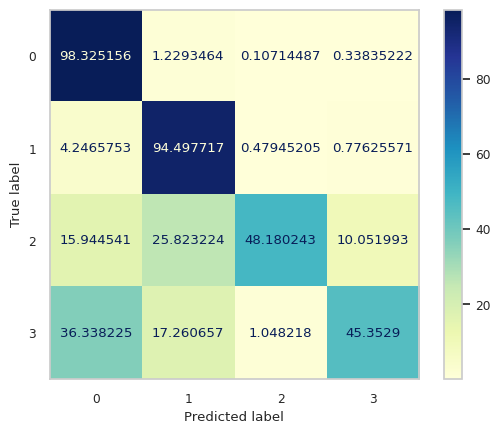

In [ ]:
cm = confusion_matrix(y_train , results_LR, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("LR_cm.png",bbox_inches='tight')
#files.download("LR_cm.png")

**Catboost**

In [ ]:
! pip install catboost
from catboost import CatBoostClassifier


model_CB=CatBoostClassifier(random_state=random_state)

scores=cross_val_score(model_CB, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.3 MB/s eta 0:00:00


array([0.89445447, 0.90695388, 0.88594944, 0.91428887, 0.88286211,
       0.87796056, 0.90096002, 0.88617867, 0.88949825, 0.91427814])

In [ ]:
! pip install  catboost
from catboost import CatBoostClassifier

model_CB=CatBoostClassifier(random_state=random_state)

results_CB=cross_val_predict(model_CB,X_train,y_train,cv=cvk)

Streaming output truncated to the last 5000 lines.
4:	learn: 0.7034782	total: 124ms	remaining: 24.8s
5:	learn: 0.6365838	total: 151ms	remaining: 25s
6:	learn: 0.5785532	total: 177ms	remaining: 25s
7:	learn: 0.5296556	total: 214ms	remaining: 26.6s
8:	learn: 0.4871485	total: 240ms	remaining: 26.4s
9:	learn: 0.4480086	total: 271ms	remaining: 26.8s
10:	learn: 0.4152828	total: 297ms	remaining: 26.7s
11:	learn: 0.3860872	total: 322ms	remaining: 26.5s
12:	learn: 0.3605090	total: 347ms	remaining: 26.4s
13:	learn: 0.3366086	total: 373ms	remaining: 26.2s
14:	learn: 0.3154682	total: 400ms	remaining: 26.2s
15:	learn: 0.2960996	total: 439ms	remaining: 27s
16:	learn: 0.2791872	total: 466ms	remaining: 26.9s
17:	learn: 0.2629941	total: 496ms	remaining: 27s
18:	learn: 0.2496559	total: 521ms	remaining: 26.9s
19:	learn: 0.2375444	total: 547ms	remaining: 26.8s
20:	learn: 0.2267474	total: 573ms	remaining: 26.7s
21:	learn: 0.2159941	total: 599ms	remaining: 26.6s
22:	learn: 0.2069853	total: 624ms	remaining: 

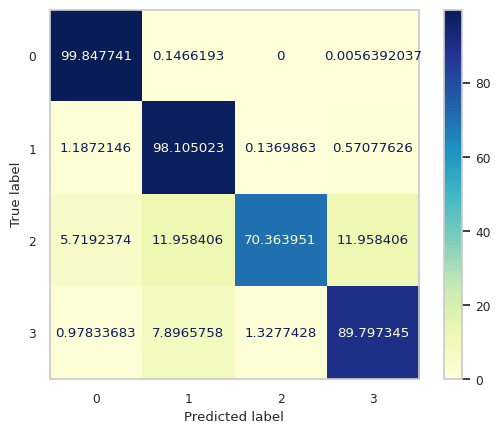

In [ ]:
cm = confusion_matrix(y_train , results_CB, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("CB_cm.png",bbox_inches='tight')
#files.download("CB_cm.png")

In [ ]:
print(classification_report(y_train,results_CB))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00     17733
           2       0.95      0.98      0.97      4380
           3       0.94      0.70      0.81       577
           4       0.93      0.90      0.91      1431

    accuracy                           0.98     24121
   macro avg       0.96      0.90      0.92     24121
weighted avg       0.98      0.98      0.98     24121



In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_train,results_CB)))
print("precision = " + str (precision_score(y_train,results_CB,average="macro")))
print("recall = " + str (recall_score(y_train,results_CB,average="macro")))
print("F1 = " + str (f1_score(y_train,results_CB,average="macro")))
#print("FPR = " + str (FPR.mean()))

accuracy = 0.9822975830189461
precision = 0.9553559057077905
recall = 0.8952851507935328
F1 = 0.9208809030057798


In [ ]:
cm = confusion_matrix(y_train , results_CB, )
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

In [ ]:
FPR.mean()

0.00782074087460042

In [ ]:
model_LR=LogisticRegression(random_state=random_state)
model_AB=AdaBoostClassifier(model_LR)

scores=cross_val_score(model_AB, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


array([0.6717341 , 0.65523507, 0.66804792, 0.67821809, 0.66485651,
       0.66614047, 0.6767567 , 0.67961312, 0.65786703, 0.68896961])

In [ ]:
model_AB=AdaBoostClassifier(model_LR)

results_AB=cross_val_predict(model_AB,X_train,y_train,cv=cvk)

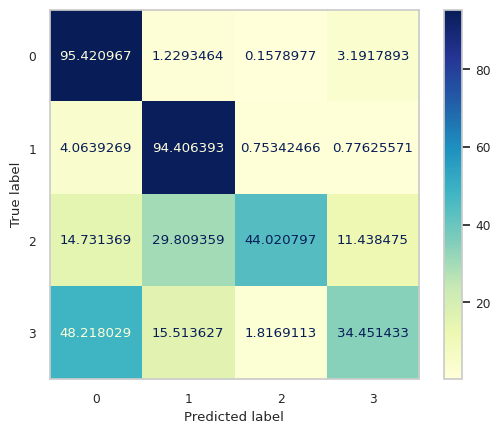

In [ ]:
cm = confusion_matrix(y_train , results_AB, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')
plt.savefig("AB_cm.png",bbox_inches='tight')
#files.download("AB_cm.png")

**LightGBM**

In [ ]:
model_LGB = lgb.LGBMClassifier()
scores=cross_val_score(model_DT, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)
#model_DT, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1

array([0.89124539, 0.88280689, 0.86255098, 0.89941089, 0.88977119,
       0.84782638, 0.87564418, 0.89256959, 0.8734098 , 0.90773803])

In [ ]:
model_LGB = lgb.LGBMClassifier()

results_LGB=cross_val_predict(model_DT,X_train,y_train,cv=cvk)

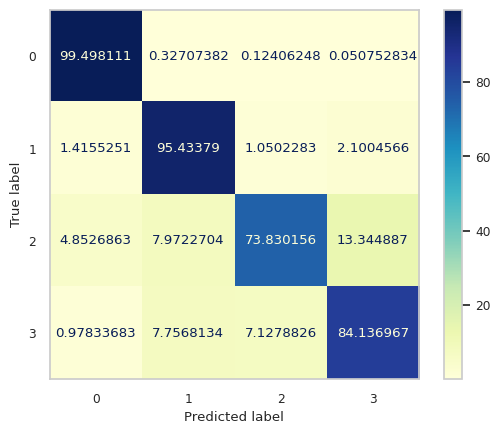

In [ ]:
cm = confusion_matrix(y_train , results_LGB, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("LGB_cm.png",bbox_inches='tight')
#files.download("LGB_cm.png")

**Stochastic Gradient Descent**

In [ ]:
model_SGD = SGDClassifier(random_state=random_state)

scores=cross_val_score(model_SGD, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


array([0.70663892, 0.67828599, 0.69519078, 0.70421011, 0.70085542,
       0.67951171, 0.66505808, 0.71909663, 0.67991908, 0.71376224])

In [ ]:
model_SGD = SGDClassifier(random_state=random_state)

results_SGD=cross_val_predict(model_SGD,X_train,y_train,cv=cvk)

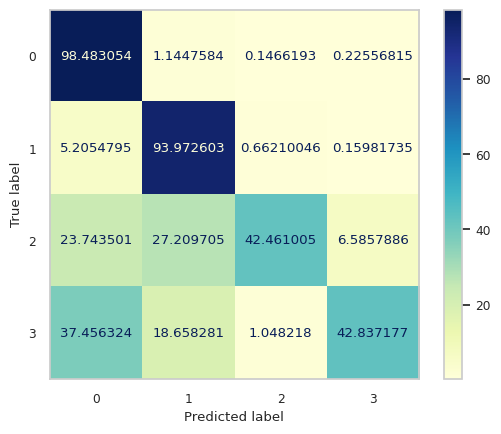

In [ ]:
cm = confusion_matrix(y_train , results_SGD, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("SGD_cm.png",bbox_inches='tight')
#files.download("SGD_cm.png")

**Ridge Classifier**

In [ ]:
model_RC = RidgeClassifier()
cross_val_score(model_RC, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)

cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

array([0.70663892, 0.67828599, 0.69519078, 0.70421011, 0.70085542,
       0.67951171, 0.66505808, 0.71909663, 0.67991908, 0.71376224])

In [ ]:
model_RC = RidgeClassifier()

results_RC=cross_val_predict(model_RC,X_train,y_train,cv=cvk)

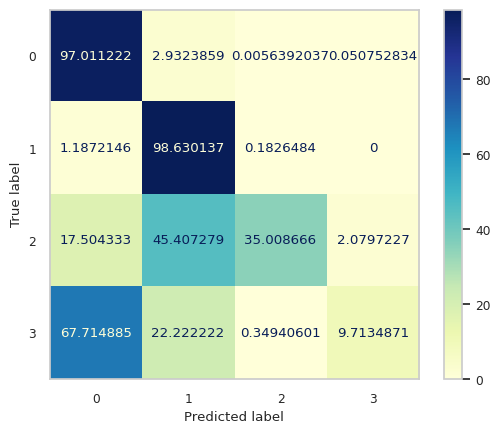

In [ ]:
cm = confusion_matrix(y_train , results_RC, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("RC_cm.png",bbox_inches='tight')
#files.download("RC_cm.png")

**Collecting results**

In [ ]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree",
"RandomForest","LogisticRegression","CatBoostClassifier","AdaBoost","LightGBM"," StochasticGradientDescent","RidgeClassifier"]})

In [ ]:
cv_res

In [ ]:
inplace=True
temp=cv_res

In [ ]:
temp = cv_res.drop(axis=0,index=6 )

In [ ]:
cv_res

In [ ]:
temp

In [ ]:
temp = temp.drop(axis=0,index=2)

In [ ]:
temp=temp.reset_index(drop=True)

temp

In [ ]:
plt.figure(figsize=(15, 10))


sns.set(font_scale=2.2 )
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'},font_scale=2.2)

g = sns.barplot("CrossValMeans","Algorithm",data = temp.sort_values(["CrossValMeans"],ascending=False), palette="YlGnBu_r",orient = "h",  );
g.set_xlabel("Mean Recall", size = 30);
g.set_ylabel("Algorithm", size = 30);
g = g.set_title("\nCross Validation Scores\n", size = 32);


plt.savefig("all_score.png",bbox_inches='tight')
#files.download("all_score.png")

**hyperparameters tunning**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


random_state = 42

model_RF=RandomForestClassifier(random_state=random_state)


param_grid = {
    'n_estimators': [100 ,200, 500],
    'max_features': ['auto', 'log2'],
    'max_depth' : [ 18 , 22 , 25],
}

RF_GridSCV = GridSearchCV(estimator=model_RF, param_grid=param_grid, cv= 4)
RF_GridSCV.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [18, 22, 25],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [100, 200, 500]})

In [ ]:
RF_GridSCV.best_params_

{'max_depth': 25, 'max_features': 'auto', 'n_estimators': 500}

In [ ]:
model_RF_BP = RandomForestClassifier(random_state=random_state,max_depth= 25 ,n_estimators=200)

model_RF_BP_results = cross_val_predict(model_RF_BP,X_train,y_train,cv=cvk)

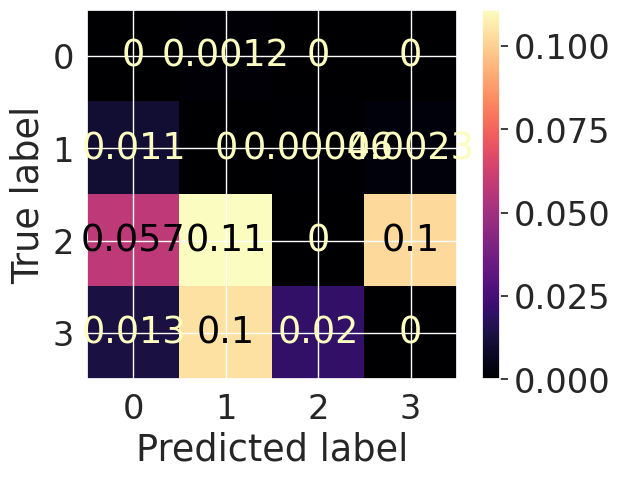

In [ ]:
cm = confusion_matrix(y_train , model_RF_BP_results )
ncm=cm /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm )
disp.plot(cmap="magma")

plt.savefig("RF_GSCVBP_cm.png",bbox_inches='tight')
#files.download("RF_GSCVBP_cm.png")

**random Forest with hyper paramters evaluation**

In [ ]:
print(classification_report(y_train,model_RF_BP_results))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00     17733
           2       0.95      0.99      0.97      4380
           3       0.93      0.73      0.82       577
           4       0.95      0.86      0.90      1431

    accuracy                           0.98     24121
   macro avg       0.96      0.89      0.92     24121
weighted avg       0.98      0.98      0.98     24121



In [ ]:
model_RF_BP.fit(X_train,y_train) #to test on the training set

RandomForestClassifier(max_depth=25, n_estimators=200, random_state=42)

In [ ]:
model_RF_BP_results_tra=model_RF_BP.predict(X_train)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_train,model_RF_BP_results_tra)))
print("precision = " + str (precision_score(y_train,model_RF_BP_results_tra,average="macro")))
print("recall = " + str (recall_score(y_train,model_RF_BP_results_tra,average="macro")))
print("F1 = " + str (f1_score(y_train,model_RF_BP_results_tra,average="macro")))

accuracy = 0.9990050163757721
precision = 0.9964277400543691
recall = 0.9908942492736351
F1 = 0.9935861344333468


In [ ]:
print(classification_report(y_train,model_RF_BP_results_tra))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     17733
           2       1.00      1.00      1.00      4380
           3       1.00      0.97      0.98       577
           4       0.99      1.00      0.99      1431

    accuracy                           1.00     24121
   macro avg       1.00      0.99      0.99     24121
weighted avg       1.00      1.00      1.00     24121



In [ ]:
model_RF_BP_results_test=model_RF_BP.predict(X_test) #testing on the test set

In [ ]:
print(classification_report(y_test,model_RF_BP_results_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      1.00      1.00      4367
           2       0.95      0.99      0.97      1180
           3       0.95      0.73      0.83       158
           4       0.94      0.84      0.89       325

    accuracy                           0.98      6031
   macro avg       0.77      0.71      0.74      6031
weighted avg       0.98      0.98      0.98      6031



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**The Vanilla Random Forest Classifier (with the default hyperparamters) evaluation.**

In [ ]:
model_RF=RandomForestClassifier(random_state=random_state)

model_RF.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_train=model_RF.predict(X_train)

In [ ]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     17733
           2       1.00      1.00      1.00      4380
           3       1.00      0.97      0.98       577
           4       0.99      1.00      0.99      1431

    accuracy                           1.00     24121
   macro avg       1.00      0.99      0.99     24121
weighted avg       1.00      1.00      1.00     24121



In [ ]:
cm = confusion_matrix(y_train , y_pred_train, )
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_train,y_pred_train)))
print("precision = " + str (precision_score(y_train,y_pred_train,average="macro")))
print("recall = " + str (recall_score(y_train,y_pred_train,average="macro")))
print("F1 = " + str (f1_score(y_train,y_pred_train,average="macro")))
print("FPR = " + str (FPR.mean()))

accuracy = 0.9992123046308197
precision = 0.9964458366219416
recall = 0.9920263368564601
F1 = 0.9941724610598752
FPR = 0.00020894366999732092


In [ ]:
y_pred=model_RF.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      1.00      1.00      4367
           2       0.95      0.98      0.97      1180
           3       0.95      0.74      0.83       158
           4       0.93      0.84      0.89       325

    accuracy                           0.98      6031
   macro avg       0.77      0.71      0.74      6031
weighted avg       0.98      0.98      0.98      6031



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_test , y_pred )
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

<ipython-input-215-0e483b87ab4b>:12: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
<ipython-input-215-0e483b87ab4b>:20: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_test , y_pred )))
print("precision = " + str (precision_score(y_test , y_pred ,average="macro")))
print("recall = " + str (recall_score(y_test , y_pred ,average="macro")))
print("F1 = " + str (f1_score(y_test , y_pred ,average="macro")))
print("FPR = " + str (FPR.mean()))

accuracy = 0.9806002321339745
precision = 0.7651785741835713
recall = 0.7132673213016952
F1 = 0.7360898105241094
FPR = 0.006947092258263193


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that our model achived 98% accuracy, recall and percision on the training set , on the other hand it only achived 96% accuracy on the test set , and 94% recall.

This indicates that the model overfits the training set badly.

**CatBoost model evaluation**

In [ ]:
! pip install catboost
from catboost import CatBoostClassifier

model_CB=CatBoostClassifier(random_state=random_state)

model_CB.fit(X_train,y_train)

Learning rate set to 0.093073
0:	learn: 1.1598019	total: 56.2ms	remaining: 56.2s
1:	learn: 1.0022965	total: 85.6ms	remaining: 42.7s
2:	learn: 0.8772267	total: 112ms	remaining: 37.3s
3:	learn: 0.7783767	total: 140ms	remaining: 34.9s
4:	learn: 0.6984687	total: 164ms	remaining: 32.7s
5:	learn: 0.6318091	total: 199ms	remaining: 32.9s
6:	learn: 0.5739916	total: 226ms	remaining: 32s
7:	learn: 0.5247642	total: 254ms	remaining: 31.5s
8:	learn: 0.4817283	total: 281ms	remaining: 30.9s
9:	learn: 0.4433272	total: 314ms	remaining: 31.1s
10:	learn: 0.4107264	total: 341ms	remaining: 30.7s
11:	learn: 0.3818099	total: 371ms	remaining: 30.5s
12:	learn: 0.3563203	total: 398ms	remaining: 30.2s
13:	learn: 0.3331311	total: 430ms	remaining: 30.3s
14:	learn: 0.3124866	total: 460ms	remaining: 30.2s
15:	learn: 0.2932981	total: 488ms	remaining: 30s
16:	learn: 0.2765978	total: 516ms	remaining: 29.8s
17:	learn: 0.2615702	total: 544ms	remaining: 29.7s
18:	learn: 0.2484793	total: 569ms	remaining: 29.4s
19:	learn: 0.

In [ ]:
y_pred_train_CB=model_CB.predict(X_train)

In [ ]:
cm = confusion_matrix(y_train , y_pred_train_CB, )
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_train,y_pred_train_CB)))
print("precision = " + str (precision_score(y_train,y_pred_train_CB,average="macro")))
print("recall = " + str (recall_score(y_train,y_pred_train_CB,average="macro")))
print("F1 = " + str (f1_score(y_train,y_pred_train_CB,average="macro")))
print("FPR = " + str (FPR.mean()))

accuracy = 0.9920401310061772
precision = 0.9834899005915161
recall = 0.9482063427466594
F1 = 0.9643589774303774
FPR = 0.0032463903744377963


In [ ]:
print(classification_report(y_train,y_pred_train_CB))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     17733
           2       0.98      0.99      0.98      4380
           3       0.99      0.85      0.91       577
           4       0.97      0.95      0.96      1431

    accuracy                           0.99     24121
   macro avg       0.98      0.95      0.96     24121
weighted avg       0.99      0.99      0.99     24121



In [ ]:
y_pred_CB=model_CB.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test , y_pred_CB )
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

<ipython-input-223-269213aa5758>:12: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
<ipython-input-223-269213aa5758>:20: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_test , y_pred_CB )))
print("precision = " + str (precision_score(y_test , y_pred_CB ,average="macro")))
print("recall = " + str (recall_score(y_test , y_pred_CB ,average="macro")))
print("F1 = " + str (f1_score(y_test , y_pred_CB ,average="macro")))
print("FPR = " + str (FPR.mean()))

accuracy = 0.982921571878627
precision = 0.7662194689943373
recall = 0.7308627333069369
F1 = 0.7469508188110284
FPR = 0.006513470138003069


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(y_test,y_pred_CB))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      1.00      1.00      4367
           2       0.96      0.98      0.97      1180
           3       0.94      0.78      0.85       158
           4       0.94      0.90      0.92       325

    accuracy                           0.98      6031
   macro avg       0.77      0.73      0.75      6031
weighted avg       0.98      0.98      0.98      6031



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Deep Learning**

We will try to get a better performance for our classification task by using more complex models such as deep learning.

But let us first obtain the validation set

In [ ]:
strat_train_set["type"]=strat_train_set["type"]
X_train_full=strat_train_set
Y_train_full=strat_train_set["type"]

X_test_full=strat_test_set.drop("type",axis=1)
Y_test_full=strat_test_set["type"]

In [ ]:
X_train_full.reset_index(drop=True,inplace=True)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
for train_index, test_index in split.split(X_train_full, Y_train_full):
    XY_train = X_train_full.loc[train_index]
    XY_valid = X_train_full.loc[test_index]

NameError: name 'X_train_full' is not defined

In [ ]:
X_train= XY_train.drop("type",axis=1)
Y_train_r= XY_train["type"]

X_valid=XY_valid.drop("type",axis=1)
Y_valid_r=XY_valid["type"]

X_test=X_test_full
Y_test_r=Y_test_full

NameError: name 'XY_train' is not defined

we will use the to_categorical function to one-hot encode our labels

In [ ]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train_r, 4)
Y_valid = to_categorical(Y_valid_r, 4)
Y_test = to_categorical(Y_test_r, 4)

NameError: name 'Y_train_r' is not defined

In [ ]:
X_train.shape

(24121, 63)

In [ ]:
keras.backend.clear_session()

**Model_1**

Our initial model has 3 hidden layers, with 300, 200, 100 neurons respectively, we will use the relu activation function as it is easy to compute, the output layer will have 4 neurons which is equal to the number of classes we have, and we will use the softmax activation function in this layer,as our problem is considered a multi-class classifaction problem.

In [ ]:
model_1 = keras.models.Sequential()
model_1.add(keras.layers.Dense(300,input_dim=63, activation="relu"))
model_1.add(keras.layers.Dense(200, activation="relu"))
model_1.add(keras.layers.Dense(100, activation="relu"))
model_1.add(keras.layers.Dense(4, activation="softmax"))

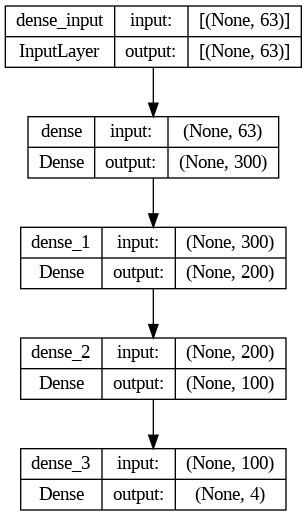

In [ ]:
keras.utils.plot_model(model_1,  show_shapes=True)

In [ ]:
 model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               19200     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 4)                 404       
                                                                 
Total params: 99904 (390.25 KB)
Trainable params: 99904 (390.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Since the dataset is not balanced the accuracy metric is not a good one to evalutae our models performance.

We will use the recall metrics instead of the accuracy, as detecting mallicious website is our main goal, and we also want to minimize the FN (False negative) rate as much as possible.

In [ ]:
model_1.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["Recall"])

In [ ]:
history = model_1.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

**Model_2**

In [ ]:
model_2 = keras.models.Sequential()
model_2.add(keras.layers.Dense(200,input_dim=63, activation="relu"))
model_2.add(keras.layers.Dense(100, activation="relu"))
model_2.add(keras.layers.Dense(4, activation="softmax"))

model_2.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["Recall"])

In [ ]:
history2 = model_2.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

In [ ]:
weights, biases =model_1.layers[3].get_weights()

In [ ]:
weights

array([[-2.03943938e-01,  2.12135643e-01,  1.15326583e-01,
         1.06195003e-01],
       [ 1.65854394e-01, -1.94404796e-01,  7.52263665e-02,
        -1.34722784e-01],
       [ 1.32005274e-01,  1.25727236e-01, -7.48436600e-02,
         2.05039829e-01],
       [-3.23924422e-02,  2.34928787e-01,  1.90696925e-01,
        -5.70214838e-02],
       [-9.08643007e-04, -1.56338066e-02,  2.11808085e-02,
         2.04873264e-01],
       [ 2.36456096e-02,  1.95815891e-01, -1.36722580e-01,
         1.62610263e-01],
       [ 2.10235149e-01,  1.48416251e-01,  1.25091165e-01,
        -7.51418471e-02],
       [ 8.92509520e-02, -1.43014550e-01,  1.19330406e-01,
        -1.83443859e-01],
       [-1.74230754e-01,  2.09685177e-01,  6.35338724e-02,
         1.88079476e-03],
       [-5.77818602e-02,  2.10450530e-01,  2.18175173e-01,
        -1.88673928e-01],
       [ 6.61665499e-02,  1.58891678e-01,  5.10298908e-02,
         1.48105413e-01],
       [ 1.35708869e-01, -8.51756483e-02, -8.65163058e-02,
      

the weights has many relatively large negative values, which probably causes a dying ReLU problem, therfore we should consider an alternative of the ReLU activation function.

let try the first model again, but this time we will use the SELU activation function, further more we will use the LeCun intializer, the combination of such intializer and activation function provide a property called self-normalization which helps in preventing the vanishing/exploding gradient problem , hence we except this new model to perform better.

We will also choose a large number of epochs along with an early stopping call back .

**Model_3**

In [ ]:
model_3 = keras.models.Sequential()
model_3.add(keras.layers.Dense(300,input_dim=63, activation="selu",kernel_initializer="lecun_normal"))
model_3.add(keras.layers.Dense(200, activation="selu",kernel_initializer="lecun_normal"))
model_3.add(keras.layers.Dense(100, activation="selu",kernel_initializer="lecun_normal"))
model_3.add(keras.layers.Dense(4, activation="softmax",kernel_initializer="lecun_normal"))

in our early stopping call back we will a patience of 10, which means that if the model's performacne didn't improve after 10 epochs, thn the training will stop, and the best weights will be restored in our case (restore_best_weights=True)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
model_3.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["Recall"])

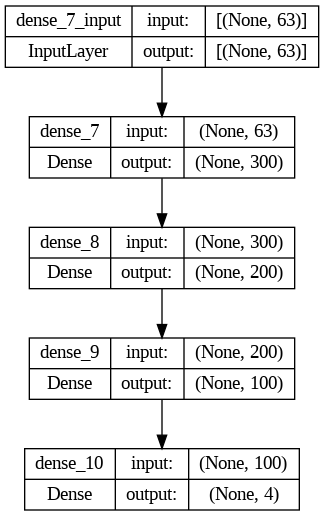

In [ ]:
keras.utils.plot_model(model_3,  show_shapes=True)

In [ ]:
history3 = model_3.fit(X_train, Y_train, epochs=60, validation_data=(X_valid, Y_valid), callbacks=[early_stopping_cb])

NameError: name 'Y_train' is not defined

In [ ]:
plt.plot(history3.history['recall'])
plt.plot(history3.history['val_recall'])
plt.title('model reacall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Model_4**

In [ ]:
model_4 = keras.models.Sequential()
model_4.add(keras.layers.Dense(300,input_dim=63, activation="selu",kernel_initializer="lecun_normal"))
model_4.add(keras.layers.BatchNormalization())
model_4.add(keras.layers.Dense(200, activation="selu",kernel_initializer="lecun_normal"))
model_4.add(keras.layers.BatchNormalization())
model_4.add(keras.layers.Dense(100, activation="selu",kernel_initializer="lecun_normal"))
model_4.add(keras.layers.BatchNormalization())
model_4.add(keras.layers.Dense(4, activation="softmax",kernel_initializer="lecun_normal"))

In [ ]:
early_stopping_cb_2 = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
performance_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.4, patience=5)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=["Recall"])

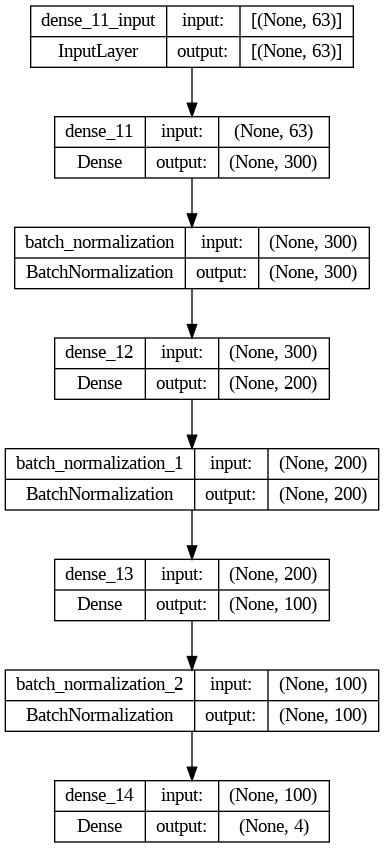

In [ ]:
keras.utils.plot_model(model_4,  show_shapes=True)

In [ ]:
history4 = model_4.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid),
                       callbacks=[early_stopping_cb_2,performance_scheduler])

In [ ]:
model_4.evaluate(X_valid,Y_valid)

The performance of our model has decreased alittle bit compaired to the previous model after adding the batch normalization.

Moreover the validation's recall performace stopped increasing after the 11th epoch when the validation recall was 0.9532, and our model stopped training after 10 epoches from that and rolled back it's weights to the values that was present at that time.

This model didn't get a better score compaired to the previous one; however, it did converge faster, this model (model_4) took 24 minutes to converge , on the other hand the previous one (model_3) took 39 minutes.

As an improvment of this model, let add a dropout layer.

We will only add two dropout layers before the 2nd and 3rd hidden layers, each having a drop rate of 20%

**Model_5**

In [ ]:
model_5 = keras.models.Sequential()
model_5.add(keras.layers.Dense(300,input_dim=63, activation="selu",kernel_initializer="lecun_normal"))
model_5.add(keras.layers.BatchNormalization())
model_5.add(keras.layers.Dropout(0.2)) #0.2
model_5.add(keras.layers.Dense(200, activation="selu",kernel_initializer="lecun_normal"))
model_5.add(keras.layers.BatchNormalization())
model_5.add(keras.layers.Dropout(0.2))
model_5.add(keras.layers.Dense(100, activation="selu",kernel_initializer="lecun_normal"))
model_5.add(keras.layers.BatchNormalization())
model_5.add(keras.layers.Dense(4, activation="softmax",kernel_initializer="lecun_normal"))

In [ ]:
early_stopping_cb_3 = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
performance_scheduler_2 = keras.callbacks.ReduceLROnPlateau(factor=0.4, patience=5)
model_5.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=["Recall"])

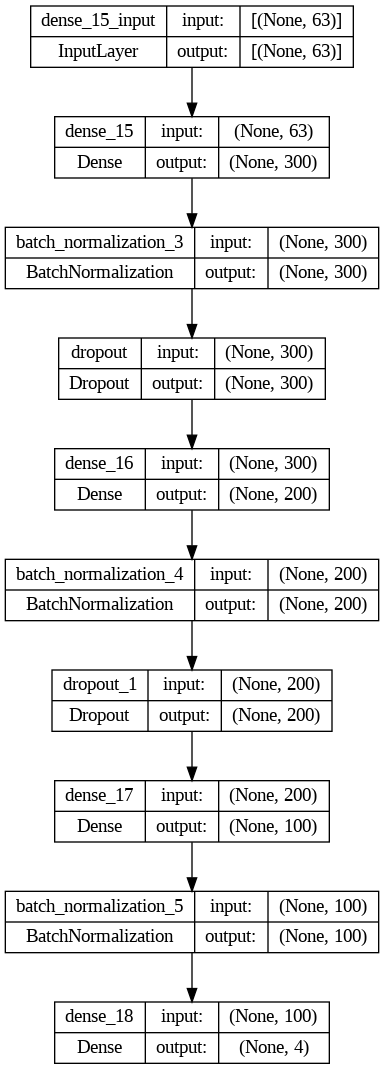

In [ ]:
keras.utils.plot_model(model_5,  show_shapes=True)

In [ ]:
history5 = model_5.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), callbacks=[early_stopping_cb_3,performance_scheduler_2])

In [ ]:
model_5.evaluate(X_valid,Y_valid)

It can be seen that this model has a better validation set recall compaired with the previous two models even though it ran for a longer time.

The validation and training recalls seems to be a little different, the validation recall is better than that of the training as can be seen from the output of the "fit" cell,this is because we have used the dropout layer, hence to get the correct training loss me must evalute the model after training (i.e. without the dropout layer) .

In [ ]:
model_5.evaluate(X_valid,Y_valid)

NameError: name 'X_valid' is not defined

In [ ]:
model_5.evaluate(X_train,Y_train)

Plotting the validation and training sets recall will not be very useful for us, as the plot will be missleading due to the fact that we have used the alpha dropout layer, however it can be seen that the plots accutally got flatten at the last 10 epoches

In [ ]:
plt.plot(history5.history['recall'])
plt.plot(history5.history['val_recall'])
plt.title('Model_5 Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**More Useful features to add**

the following is the implementation of some useful features that can be added to improve the overall performance of our model.

Unfortunatly we weren't able to add it because it requires alot of network requests which it pretty time consuming, for example to extract the below domain name features for just 100 instances it took us over 5 minutes to do it, even when using a local machine to run the code

**Domain name features**

Now we begin with the features related to the domain name itself such features include :

1- Availability of a DNS record

2- Age of domain

3- Expiration time of Domain

In [ ]:
# we need to add such a libraries to make the code work
!pip install python-whois
import re
from bs4 import BeautifulSoup
import whois
import urllib
import urllib.request
from datetime import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 1.8 MB/s eta 0:00:00


**Availability of a DNS record**

WHOIS is a protocol that is used to provide information services to the users of the internet, such informations include domain name, an IP address block or an autonomous system.

We will make use of such protocol to send a a query to the WHOIS database and check for the availability of a DNS record, malicious websites typically do not has such record as it lives for a short period of time.

the following is the type of response that we obtian from the WHOIS database, we will use the data in this response to extract more features

In [ ]:
whois.whois("facebook.com")

{'domain_name': 'FACEBOOK.COM',
 'registrar': 'RegistrarSafe, LLC',
 'whois_server': 'whois.registrarsafe.com',
 'referral_url': None,
 'updated_date': [datetime.datetime(2024, 4, 24, 19, 6, 12),
  datetime.datetime(2024, 4, 24, 19, 6, 13)],
 'creation_date': datetime.datetime(1997, 3, 29, 5, 0),
 'expiration_date': datetime.datetime(2033, 3, 30, 4, 0),
 'name_servers': ['A.NS.FACEBOOK.COM',
  'B.NS.FACEBOOK.COM',
  'C.NS.FACEBOOK.COM',
  'D.NS.FACEBOOK.COM'],
 'status': ['clientDeleteProhibited https://icann.org/epp#clientDeleteProhibited',
  'clientTransferProhibited https://icann.org/epp#clientTransferProhibited',
  'clientUpdateProhibited https://icann.org/epp#clientUpdateProhibited',
  'serverDeleteProhibited https://icann.org/epp#serverDeleteProhibited',
  'serverTransferProhibited https://icann.org/epp#serverTransferProhibited',
  'serverUpdateProhibited https://icann.org/epp#serverUpdateProhibited',
  'clientDeleteProhibited https://www.icann.org/epp#clientDeleteProhibited',
  

**Age of the doamin**

Using the response obtained from the WHOIS database we will extract this feature.

First we need to clarify that malicious websites typically live for a short period of time for many reasons for example if a malicious website lives for a long period and it conducted its malicious behaviour for a long period of time,such website will be known to the public and service providers will probably label such a website as malicious, hence when a user enter this website he will be faced with a warning.

furthermore perserving a domain name for a long period of time costs the attacker an amount of money,hence attackers tends to perservie domain names for a short period of time.

as can be seen from the above response, facebook has it's domain name preserved until 2031.

In this feature we will simpliy see if the age of the domain is older than 2 years (24 months) or not if its older then it will be set to 1 , otherwise it is set to zero

note: some of these information might be missing from the WHOIS response,which is unlickly to happen for begnin website, hence if any of such information is missing we will set the value of this feature for such instance to zero

0 for malicious

0.5 for not available

1 for benign

In [ ]:
def domainAge(domain_name):
  creation = domain_name.creation_date
  expiration = domain_name.expiration_date
  if (isinstance(creation,str) or isinstance(expiration,str)):
    try:
      creation = datetime.strptime(creation,'%Y-%m-%d')
      expiration = datetime.strptime(expiration,"%Y-%m-%d")
    except:
      return 0.5
  if ((expiration is None) or (creation is None)):
      return 0.5
  elif ((type(expiration) is list) or (type(creation) is list)):
      return 0.5
  else:
    ageofdomain = abs((expiration - creation).days)
    if ((ageofdomain/30) < 24):
      return 0
    else:
      return 1

**Expiration time of Domain**

Same as above it is useful to know much time is left for the website until its Domain name expire, however this time we will compare the expiration time from the WHOIS database with teh current time, and see if it has more than 1 year left until it expire

In [ ]:
def domainExpiration(domain_name): #this function always returns 0 needs fixing
  expiration = domain_name.expiration_date
  if isinstance(expiration,str):
    try:
      expiration = datetime.strptime(expiration,"%Y-%m-%d")
    except:
      return 0.5
  if (expiration is None):
      return 0.5
  elif (type(expiration) is list):
      return 0.5
  else:
    today = datetime.now()
    end = abs((expiration - today).days)
    if ((end/30) < 6):
      return 0
    else:
      return 1

Since all of such functions make use of the WHOIS database response we will warp it all in one function that extrat these three features

In [ ]:
def domain_features(url):
  #DNS record avilable or not
  dns = 1
  try:
    domain_name = whois.whois(url)
  except:
    return 0,0,0

  age = domainAge(domain_name)
  expiration = domainExpiration(domain_name)


  return dns, age ,expiration

In [ ]:
#df["domainFeatures"]=df['url'].apply(domain_features)

The above code retruns a tuple which is stored in the dateframe as an attribute called "domainFeatures" , the following function splits this tuple into three columns and drop the original column

In [ ]:
def domainFeaturesSplit(odf):
  odf[['DNS_available', 'DomainAge','DomainExpiration']] = pd.DataFrame(odf['domainFeatures'].tolist(), index=odf.index)
  odf.drop("domainFeatures",axis=1,inplace=True )